## Prepare Data

In [1]:
import mysql.connector 
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.mlab as mlab
from mysql.connector import errorcode
import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.html.widgets import *
import plotly as py
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import os
import json
import time
import pickle
import requests
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import configparser

%matplotlib inline

C:\Users\deeka\Anaconda3\envs\GTU\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Get seasons wise and play wise kickers and pro bowl data

In [2]:
# get connection string and stored procedure name and other configurations
def get_configuration():  
    config = configparser.ConfigParser()
    config.read('dbConfig.ini')
    global db_config, sp_kicker_data_by_season, sp_kicker_data_by_play, sp_kicker_data_by_game, sp_kicker_counts_per_season
    
    db_config = config['ConnectionString']['dbConfig']
    sp_kicker_data_by_season = config['StoredProcedures']['KickerDataPerSeason']
    sp_kicker_data_by_play = config['StoredProcedures']['KickerDataPerPlay']
    sp_kicker_data_by_game = config['StoredProcedures']['KickerDataPerGame']
    sp_kicker_counts_per_season = config['StoredProcedures']['KickerCountsPerSeason']

    return config  
    
# get features list per sason
def get_kicker_season_features():     
    return ['KICKER_ID','KICKER_NAME','SEASON','IN_PROBOWL_TEAM','SUCCESS_PRCNTG','BLOCKED_PRCNTG',
            'PLAY_COUNT','HIGH_PRESSURE_SUCCESS_PRCNTG','HIGH_PRESSURE_COUNT','LONG_DIST_SUCCESS_PRCNTG','LONG_DIST_COUNT',
            'BAD_WEATHER_SUCCESS_PRCNTG','BAD_WEATHER_COUNT','TURF_FIELD_SUCCESS_PRCNTG','TURF_FIELD_COUNT','YEARS_PLAYED',
            'DRAFT_POSITION','AGE_YEARS']

# get features list per sason
def get_kicker_play_features():     
    return ['GID','KICKER_ID','KICKER_NAME','SEASON','SUCCESS','BLOCKED','HIGH_PRESSURE','HIGH_PRESSURE_SUCCESS','LONG_DIST',
            'LONG_DIST_SUCCESS','YDS_BEHIND_LOS','IN_PROBOWL_TEAM','BAD_WEATHER','BAD_WEATHER_SUCCESS','TURF_FIELD',
            'TURF_FIELD_SUCCESS','YEARS_PLAYED','DRAFT_POSITION','AGE_YEARS']       


# get per season data from mysql db
def fetch_data(procedure, columns):   
    try:
        cnx = mysql.connector.connect(**eval(db_config))
        cursor = cnx.cursor()
        cursor.callproc(procedure)
 
        # print out the result
        for result in cursor.stored_results():
            df = DataFrame(result.fetchall())  
            
        df.columns = columns
        cnx.commit()
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with your user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
    else:
        
        return df
        cursor.close()
        cnx.close()        

In [3]:
def start():
    global config, features_kicker_by_season, features_kicker_by_play, df_kicker_by_season, df_kicker_by_play
    config = get_configuration()
    features_kicker_by_season = get_kicker_season_features()
    features_kicker_by_play = get_kicker_play_features()
    df_kicker_by_season = fetch_data(sp_kicker_data_by_season,features_kicker_by_season)    
    df_kicker_by_play = fetch_data(sp_kicker_data_by_play,features_kicker_by_play)  
    print('df_kicker_by_season: {}'.format(df_kicker_by_season.shape))
    print('df_kicker_by_play: {}'.format(df_kicker_by_play.shape))

start()    

df_kicker_by_season: (711, 18)
df_kicker_by_play: (40164, 19)


# Data Analysis

### We will play with season data first

### Per-kick totals between pro-bowl kickers and non-pro-bowl kickers

0    669
1     42
Name: IN_PROBOWL_TEAM, dtype: int64

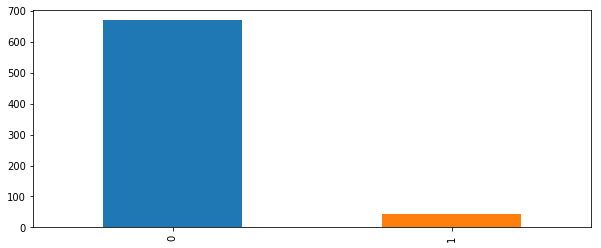

In [4]:
plt.figure(figsize=(10,4))
df_kicker_by_season["IN_PROBOWL_TEAM"].value_counts().plot(kind='bar')
df_kicker_by_season["IN_PROBOWL_TEAM"].value_counts()

There are not many instances, we can also try per play data which will give us more instances to play with.


In [5]:
df_kicker_by_play["IN_PROBOWL_TEAM"].value_counts()

0    36813
1     3351
Name: IN_PROBOWL_TEAM, dtype: int64

### Missing value treatement

In [6]:
#missing value check
def get_missing_values_count(df):
    return df.isnull().sum().sum()

print('Missing vlaues count for per seasson data: {}'.format(get_missing_values_count(df_kicker_by_season)))
print('Missing vlaues count for per play data: {}'.format(get_missing_values_count(df_kicker_by_play)))


Missing vlaues count for per seasson data: 403
Missing vlaues count for per play data: 0


In [7]:
df_kicker_by_season.isnull().sum()

KICKER_ID                         0
KICKER_NAME                       0
SEASON                            0
IN_PROBOWL_TEAM                   0
SUCCESS_PRCNTG                    0
BLOCKED_PRCNTG                    0
PLAY_COUNT                        0
HIGH_PRESSURE_SUCCESS_PRCNTG      0
HIGH_PRESSURE_COUNT               0
LONG_DIST_SUCCESS_PRCNTG          0
LONG_DIST_COUNT                   0
BAD_WEATHER_SUCCESS_PRCNTG      359
BAD_WEATHER_COUNT                 0
TURF_FIELD_SUCCESS_PRCNTG        44
TURF_FIELD_COUNT                  0
YEARS_PLAYED                      0
DRAFT_POSITION                    0
AGE_YEARS                         0
dtype: int64

#### Handle missing values
There are a couple of columns that are missing some data. BAD_WEATHER_SUCCESS_PRCNTG and TURF_FIELD_SUCCESS_PRCNTG are missing data. We can either remove these columns but then we will loose some singnals while predicting.

Because those columns have been aggregated into percentage columns, we can use the population's mean to fill in that small set of missing data. 

In [8]:
def imputation_missing_values_with_mean(df):
    df = df.apply(pd.to_numeric, errors='ignore')
    df = df.fillna(df.mean())
    return df

df_kicker_by_season=imputation_missing_values_with_mean(df_kicker_by_season)    
df_kicker_by_season.isnull().sum()

KICKER_ID                       0
KICKER_NAME                     0
SEASON                          0
IN_PROBOWL_TEAM                 0
SUCCESS_PRCNTG                  0
BLOCKED_PRCNTG                  0
PLAY_COUNT                      0
HIGH_PRESSURE_SUCCESS_PRCNTG    0
HIGH_PRESSURE_COUNT             0
LONG_DIST_SUCCESS_PRCNTG        0
LONG_DIST_COUNT                 0
BAD_WEATHER_SUCCESS_PRCNTG      0
BAD_WEATHER_COUNT               0
TURF_FIELD_SUCCESS_PRCNTG       0
TURF_FIELD_COUNT                0
YEARS_PLAYED                    0
DRAFT_POSITION                  0
AGE_YEARS                       0
dtype: int64

## Feature analysis & selection

### Check if it is separable classficiation problem

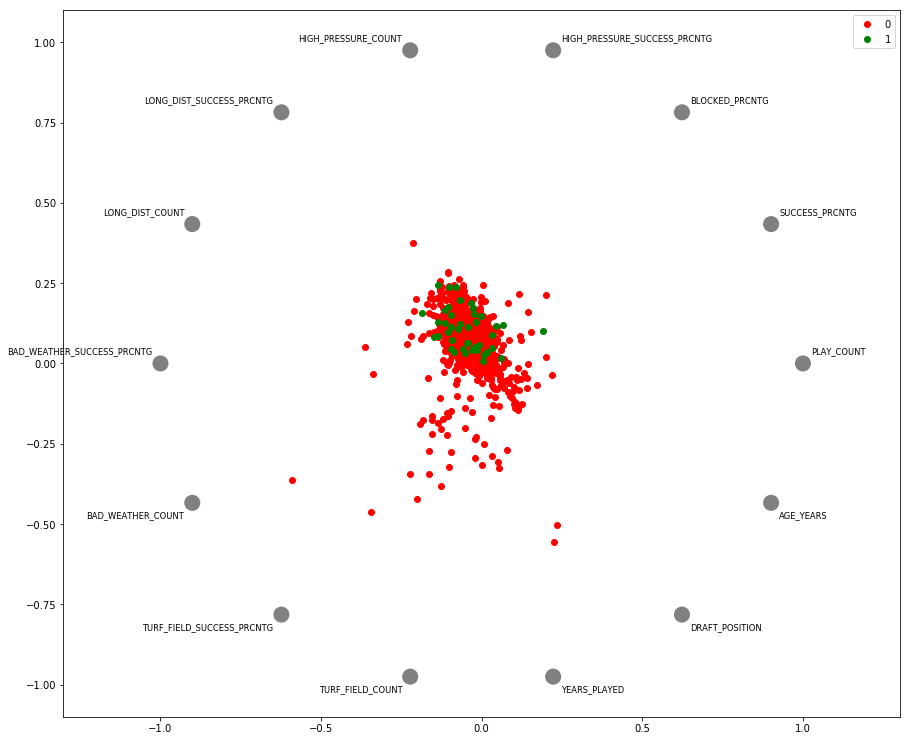

In [9]:
#check if it is separable classficiation problem
    
df_kicker_by_season[['PLAY_COUNT','SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','HIGH_PRESSURE_COUNT',
                     'LONG_DIST_SUCCESS_PRCNTG','LONG_DIST_COUNT', 'BAD_WEATHER_SUCCESS_PRCNTG','BAD_WEATHER_COUNT',
                     'TURF_FIELD_SUCCESS_PRCNTG','TURF_FIELD_COUNT','YEARS_PLAYED','AGE_YEARS']]=df_kicker_by_season[['PLAY_COUNT','SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','HIGH_PRESSURE_COUNT','LONG_DIST_SUCCESS_PRCNTG','LONG_DIST_COUNT', 'BAD_WEATHER_SUCCESS_PRCNTG','BAD_WEATHER_COUNT',
                     'TURF_FIELD_SUCCESS_PRCNTG','TURF_FIELD_COUNT','YEARS_PLAYED','AGE_YEARS']].apply(pd.to_numeric)

#DATA = DATA[DATA['PLAY_COUNT']>55]
#DATA = DATA[DATA['SUCCESS_PRCNTG']>80]
from pandas.plotting import radviz
plt.figure(figsize=(15,13))
radviz(df_kicker_by_season[['PLAY_COUNT','SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','HIGH_PRESSURE_COUNT','LONG_DIST_SUCCESS_PRCNTG','LONG_DIST_COUNT', 'BAD_WEATHER_SUCCESS_PRCNTG','BAD_WEATHER_COUNT',
                     'TURF_FIELD_SUCCESS_PRCNTG','TURF_FIELD_COUNT','YEARS_PLAYED','DRAFT_POSITION','AGE_YEARS','IN_PROBOWL_TEAM']], 'IN_PROBOWL_TEAM', color=['red','green'])

This looks like good separaable classification problem.

### Check Features correlations

In [10]:
# check correlation among quantitaive features and pick only one feature out of two too correlated features
corr_matrix = df_kicker_by_season.corr().abs()
high_corr_var=np.where(corr_matrix>0.7)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

[('PLAY_COUNT', 'HIGH_PRESSURE_COUNT'), ('YEARS_PLAYED', 'AGE_YEARS')]

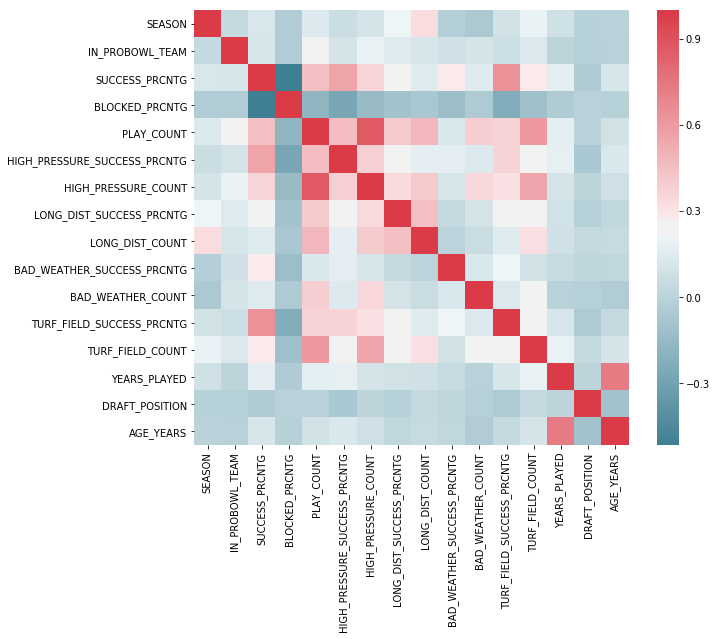

In [11]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df_kicker_by_season.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

These are some abious correaltion HIGH_PRESSURE_COUNT to PLAY_OUT and YEARS_PLAYED to AGE_YEARS. We will keep one of these fields.

FEATURES_SELECTED =['Player_ID', 'GID', 'Season', 'Is_Weather_Extreme', 'Is_Turf_Surface',
       'Success', 'Blocked', 'Is_High_Pressure', 'High_Pressure_Success',
       'Is_Long_Distance', 'Long_Distance_Success', 'YDS_Behind_LOS',
       'Distance', 'YEARS_PLAYED', 'TEMP', 'HUMD', 'WSPD', 'height', 'weight',
       'forty', 'bench', 'vertical', 'broad', 'shuttle', 'arm',
       'dcp', 'Draft_Position', 'In_ProBowlTeam']
DATA=DATA[FEATURES_SELECTED]

In [75]:
def adjust_data_for_selected_features(df):
    FEATURES_SELECTED =['KICKER_ID', 'KICKER_NAME', 'SEASON', 'SUCCESS_PRCNTG', 'BLOCKED_PRCNTG', 'PLAY_COUNT',
       'HIGH_PRESSURE_SUCCESS_PRCNTG', 'HIGH_PRESSURE_COUNT','LONG_DIST_SUCCESS_PRCNTG', 'LONG_DIST_COUNT',
       'BAD_WEATHER_SUCCESS_PRCNTG', 'BAD_WEATHER_COUNT','TURF_FIELD_SUCCESS_PRCNTG', 'TURF_FIELD_COUNT', 
       'YEARS_PLAYED','DRAFT_POSITION','IN_PROBOWL_TEAM']
    
    return df[FEATURES_SELECTED]

df_kicker_by_season = adjust_data_for_selected_features(df_kicker_by_season)
df_kicker_by_season['SEASON']=df_kicker_by_season['SEASON'].astype(int)

#### Pro Bowl Kicker data

In [111]:
# get only pro bowl kickers 
df_kicker_by_season_pro_bowl = df_kicker_by_season[df_kicker_by_season['IN_PROBOWL_TEAM']==1]

# Aggregate kickers data by season
df_pro_bowl_agg_by_season=DataFrame(df_kicker_by_season_pro_bowl.groupby(['SEASON']).agg({
    'SUCCESS_PRCNTG': np.min, 
    'BLOCKED_PRCNTG': np.max, 
    'HIGH_PRESSURE_SUCCESS_PRCNTG': np.min, 
    'LONG_DIST_SUCCESS_PRCNTG': np.min, 
    'BAD_WEATHER_SUCCESS_PRCNTG': np.min,
    'TURF_FIELD_SUCCESS_PRCNTG': np.min,
    'PLAY_COUNT': np.min, 
    'HIGH_PRESSURE_COUNT':np.min,
    'LONG_DIST_COUNT': np.min,  
    'BAD_WEATHER_COUNT': np.min, 
    'TURF_FIELD_COUNT': np.min, 
}))

df_pro_bowl_agg_by_season.reset_index(inplace=True)
df_pro_bowl_agg_by_season

,SEASON,SUCCESS_PRCNTG,BLOCKED_PRCNTG,HIGH_PRESSURE_SUCCESS_PRCNTG,LONG_DIST_SUCCESS_PRCNTG,BAD_WEATHER_SUCCESS_PRCNTG,TURF_FIELD_SUCCESS_PRCNTG,PLAY_COUNT,HIGH_PRESSURE_COUNT,LONG_DIST_COUNT,BAD_WEATHER_COUNT,TURF_FIELD_COUNT
0,2000,92.2078,1.2987,78.5714,66.6667,100.000000,88.8889,77,12.0,3.0,3.0,4.0
1,2001,92.5373,1.4925,85.7143,50.0000,87.500000,91.6667,67,7.0,3.0,8.0,12.0
2,2002,94.0476,0.0000,84.6154,33.3333,100.000000,95.0820,66,6.0,2.0,2.0,15.0
3,2003,83.3333,0.0000,100.0000,0.0000,86.182492,0.0000,6,2.0,1.0,0.0,1.0
4,2004,93.1034,1.1494,87.5000,0.0000,86.182492,94.7368,87,8.0,1.0,0.0,19.0
5,2005,86.0000,1.3699,87.5000,0.0000,50.000000,100.0000,50,8.0,0.0,2.0,5.0
6,2006,95.6044,1.0204,93.3333,0.0000,100.000000,90.0000,91,10.0,0.0,4.0,20.0
7,2007,92.8571,1.1494,80.0000,40.0000,66.666700,91.6667,70,10.0,5.0,3.0,12.0
8,2008,93.8272,2.4691,84.6154,100.0000,91.666700,91.0714,80,12.0,1.0,5.0,56.0
9,2009,91.6667,3.5714,82.3529,33.3333,86.182492,81.2500,66,8.0,2.0,0.0,7.0


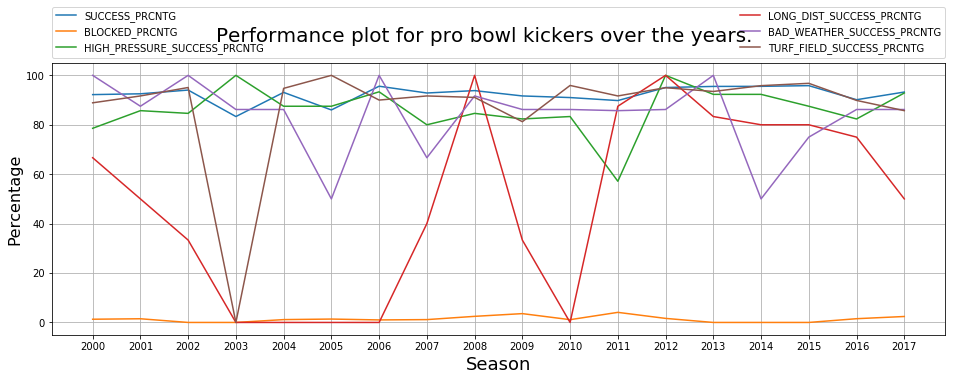

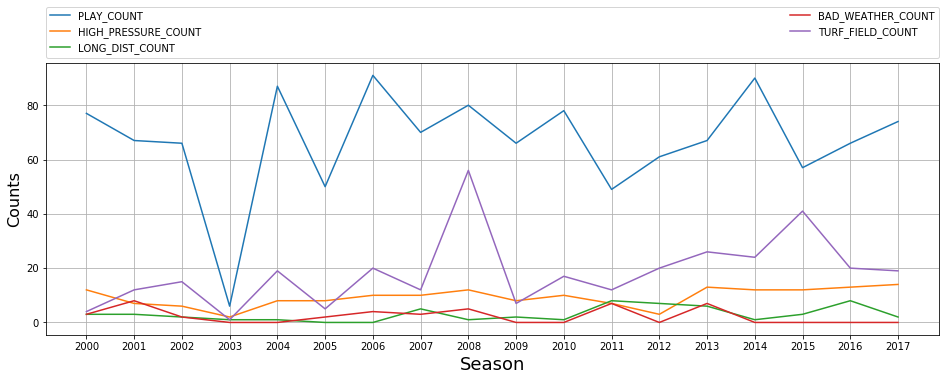

In [84]:
plt.figure(figsize=(16, 5)) 
plt.plot(df_pro_bowl_agg_by_season['SEASON'], df_pro_bowl_agg_by_season['SUCCESS_PRCNTG'])
plt.plot(df_pro_bowl_agg_by_season['SEASON'], df_pro_bowl_agg_by_season['BLOCKED_PRCNTG'])
plt.plot(df_pro_bowl_agg_by_season['SEASON'], df_pro_bowl_agg_by_season['HIGH_PRESSURE_SUCCESS_PRCNTG'])
plt.plot(df_pro_bowl_agg_by_season['SEASON'], df_pro_bowl_agg_by_season['LONG_DIST_SUCCESS_PRCNTG'])
plt.plot(df_pro_bowl_agg_by_season['SEASON'], df_pro_bowl_agg_by_season['BAD_WEATHER_SUCCESS_PRCNTG'])
plt.plot(df_pro_bowl_agg_by_season['SEASON'], df_pro_bowl_agg_by_season['TURF_FIELD_SUCCESS_PRCNTG'])

plt.suptitle('Performance plot for pro bowl kickers over the years.', fontsize=20)
plt.ylabel('Percentage')
plt.xlabel('Season', fontsize=18)
plt.ylabel('Percentage', fontsize=16)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

plt.xticks(df_pro_bowl_agg_by_season['SEASON'])
plt.grid()
plt.show()

plt.figure(figsize=(16, 5)) 
plt.plot(df_pro_bowl_agg_by_season['SEASON'], df_pro_bowl_agg_by_season['PLAY_COUNT'])
plt.plot(df_pro_bowl_agg_by_season['SEASON'], df_pro_bowl_agg_by_season['HIGH_PRESSURE_COUNT'])
plt.plot(df_pro_bowl_agg_by_season['SEASON'], df_pro_bowl_agg_by_season['LONG_DIST_COUNT'])
plt.plot(df_pro_bowl_agg_by_season['SEASON'], df_pro_bowl_agg_by_season['BAD_WEATHER_COUNT'])
plt.plot(df_pro_bowl_agg_by_season['SEASON'], df_pro_bowl_agg_by_season['TURF_FIELD_COUNT'])

plt.xlabel('Season', fontsize=18)
plt.ylabel('Counts', fontsize=16)


plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xticks(df_pro_bowl_agg_by_season['SEASON'])
plt.grid()
plt.show()

Visible pattern from above plots, overall success remain same over the years except long distance (2003-2006, 2010) and 
turf fields (2003)

Play counts (2003) are exception otherwise counts remains same.
Need to analyse 2003 more.

In [113]:
# get only non pro bowl kickers 
df_kicker_by_season_non_pro_bowl=df_kicker_by_season[df_kicker_by_season['SEASON']==2003]
df_kicker_by_season_non_pro_bowl.sort_values(by=['IN_PROBOWL_TEAM'],ascending=False)

,KICKER_ID,KICKER_NAME,SEASON,SUCCESS_PRCNTG,BLOCKED_PRCNTG,PLAY_COUNT,HIGH_PRESSURE_SUCCESS_PRCNTG,HIGH_PRESSURE_COUNT,LONG_DIST_SUCCESS_PRCNTG,LONG_DIST_COUNT,BAD_WEATHER_SUCCESS_PRCNTG,BAD_WEATHER_COUNT,TURF_FIELD_SUCCESS_PRCNTG,TURF_FIELD_COUNT,YEARS_PLAYED,DRAFT_POSITION,IN_PROBOWL_TEAM
146,JW-3300,J.Wilkins,2003,95.7447,0.0000,94,100.0000,18.0,83.3333,6.0,90.909100,11.0,97.058800,68.0,9.0,0,1
131,CH-2900,C.Hentrich,2003,83.3333,0.0000,6,100.0000,2.0,0.0000,1.0,86.182492,0.0,0.000000,1.0,9.0,200,1
153,MV-0100,M.Vanderjagt,2003,100.0000,0.0000,98,100.0000,17.0,100.0000,1.0,100.000000,8.0,100.000000,60.0,5.0,0,1
126,AE-0700,A.Elling,2003,89.1892,0.0000,74,94.4444,18.0,33.3333,3.0,86.182492,0.0,90.740700,54.0,0.0,0,0
157,PD-0200,P.Dawson,2003,90.2439,2.4390,41,100.0000,3.0,100.0000,2.0,100.000000,9.0,100.000000,3.0,5.0,0,0
150,MG-1200,M.Gramatica,2003,81.6667,10.0000,60,60.0000,10.0,33.3333,3.0,71.428600,7.0,77.777800,9.0,4.0,80,0
151,MK-1100,M.Knorr,2003,100.0000,0.0000,2,100.0000,1.0,0.0000,0.0,86.182492,0.0,89.064073,0.0,3.0,0,0
152,MS-5200,M.Stover,2003,93.2432,0.0000,74,94.1176,17.0,0.0000,2.0,86.182492,0.0,94.000000,50.0,13.0,329,0
154,NR-0100,N.Rackers,2003,85.0000,0.0000,20,100.0000,2.0,0.0000,0.0,100.000000,2.0,50.000000,4.0,3.0,169,0
155,OM-0100,O.Mare,2003,87.3016,3.1746,63,75.0000,12.0,66.6667,6.0,86.182492,0.0,94.736800,19.0,6.0,0,0


## Prepare data for modeling

In [175]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
import time 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split as tts 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier


# get quantitaive features
def prepare_data_for_modeling(df, training_cut_off, test_season):
    df.apply(pd.to_numeric, errors='ignore')  

    scaler = MinMaxScaler()
    
    global X_train, X_test, y_train, y_test, X, y, dt_predict_data, target_predict
    #data for modeling , before 2016 data
    dt_modeling = df[df['SEASON'] <= training_cut_off].iloc[:,3:]
    train_data=scaler.fit_transform(dt_modeling.iloc[:, 0:-1])
    train_data=dt_modeling.iloc[:, 0:-1]
    #dt_modeling_data = pd.DataFrame(train_data,index=train_data[:,0])
    dt_modeling_data=dt_modeling.iloc[:, 0:-1]
    target_modeling =dt_modeling.iloc[:, -1]
    # Identify our data and target 
    X = dt_modeling_data
    y = target_modeling

    # Create random train and test splits to avoid bais and overfitting
    splits = tts(X, y, test_size=1)
    X_train, X_test, y_train, y_test = splits

    #data for out of bag testing of model - 2016/2017 dta
    dt_predict = df[df['SEASON']==test_season].iloc[:,3:]
    dt_predict_data = dt_predict.iloc[:, 0:-1]
    target_predict = dt_predict.iloc[:, -1]

# prepare models    
results=[]
names=[]

def fit_model(model, name, X_train, X_test, y_train, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start 
    score = model.score(X_test, y_test)
    
    print("{} fit in {:0.2f} seconds score: {:0.4f}".format(model.__class__.__name__, duration, score))
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    scoring = 'accuracy'
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    #print(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)    

LogisticRegression fit in 0.00 seconds score: 1.0000
LinearDiscriminantAnalysis fit in 0.00 seconds score: 1.0000
DecisionTreeClassifier fit in 0.00 seconds score: 1.0000
KNeighborsClassifier fit in 0.00 seconds score: 1.0000
RandomForestClassifier fit in 0.01 seconds score: 1.0000
GaussianNB fit in 0.00 seconds score: 1.0000
AdaBoostClassifier fit in 0.00 seconds score: 1.0000
VotingClassifier fit in 0.02 seconds score: 1.0000


C:\Users\deeka\Anaconda3\envs\GTU\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\deeka\Anaconda3\envs\GTU\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\deeka\Anaconda3\envs\GTU\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\deeka\Anaconda3\envs\GTU\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning Fa

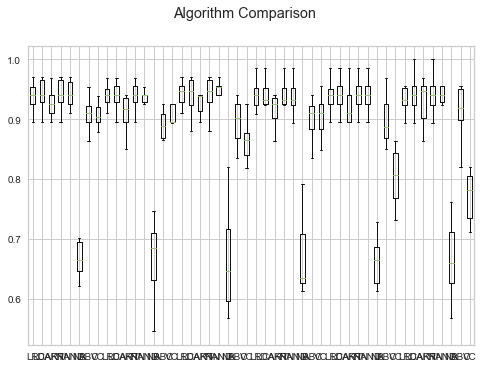

In [186]:
models = []
def train_test_all_models(df, training_cut_off, test_season):
    # Training classifiers
    LR = LogisticRegression()
    LDA = LinearDiscriminantAnalysis()
    CART = DecisionTreeClassifier(max_depth=6)
    KNN = KNeighborsClassifier(n_neighbors=12)
    RAND = RandomForestClassifier()
    #SVC = SVC(kernel='rbf', probability=True)
    NB=GaussianNB()
    ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=100),
                             algorithm="SAMME",
                             n_estimators=500)
    #VC = VotingClassifier(estimators=[('dt', CART), ('knn', KNN), ('svc', SVC)], voting='soft', weights=[3,3,3])
    VC = VotingClassifier(estimators=[('abc', ABC), ('nb', NB), ('RAND', RAND)], voting='soft', weights=[5,5,1])

    
    models.append(('LR', LR))
    models.append(('LDA', LDA))
    models.append(('CART', CART))
    models.append(('KNN', KNN))
    models.append(('RAND', RAND))
    #models.append(('SVC', SVC))
    models.append(('NB', NB))
    models.append(('ABC', ABC))
    models.append(('VC', VC))
    
    prepare_data_for_modeling(df, training_cut_off, test_season)

    for name,model in models:
        fit_model(model, name, X_train, X_test, y_train, y_test)    
        # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()
    
train_test_all_models(df_kicker_by_season, 2016, 2017)

In [187]:
def prepare_data_for_predict(df, season):
    global dt_predict_data, target_predict
    dt_predict = df[df['SEASON']==season].iloc[:,3:]
    dt_predict_data = dt_predict.iloc[:, 0:-1]
    target_predict = dt_predict.iloc[:, -1]  
    
    # 2016 - 36 0:33 1:3
    # 2017 - 43 0:40 1:3

prepare_data_for_predict(df_kicker_by_season, 2017)

def predict_model(model, df, season):
    global d
    yhat = model.predict(dt_predict_data)
    print(classification_report(target_predict, yhat))
      # Instantiate the classification model and visualizer
    #visualizer = ClassificationReport(model, classes=['No', 'Yes'])    
    #visualizer.poof()    
    
    d= df.loc[(df["SEASON"]==season)]
    d['PREDICTION'] = yhat
    #print("Season: {}, 0s: {}, 1s:{}".format(seas,len(X[X['INPROBOWLTEAM'] ==0]),len(X[X['INPROBOWLTEAM'] ==1])))
    unmatched_results = d.loc[( d['PREDICTION'] != d['IN_PROBOWL_TEAM'])]
    matched_results = d.loc[( d['PREDICTION'] == d['IN_PROBOWL_TEAM'])]
    print("unmatched: count {}, ".format(len(unmatched_results), unmatched_results))
    print("Matched: count {},".format(len(matched_results), matched_results))

    #print(d.loc[( d['yhat'] != d['IN_PROBOWL_TEAM']),['KICKER_ID','KICKER_NAME','IN_PROBOWL_TEAM','yhat']])
    print('Predicted players {}'.format(d.loc[( d['PREDICTION'] == 1),'KICKER_ID'].unique()))
    print('Actual players {}'.format(d.loc[( d['IN_PROBOWL_TEAM'] == 1),'KICKER_ID'].unique()))

    
    #print(len(DATA.loc[(DATA["SEASON"]==seas) & (DATA["INPROBOWLTEAM"] == yhat), "INPROBOWLTEAM"]))
    

for name, model in models:
    print('MODEL-{}'.format(name))
    predict_model(model, df_kicker_by_season, 2017)  

MODEL-LR
             precision    recall  f1-score   support

          0       0.93      1.00      0.96        40
          1       0.00      0.00      0.00         3

avg / total       0.87      0.93      0.90        43

unmatched: count 3, 
Matched: count 40,
Predicted players []
Actual players ['CB-2275' 'GG-0100' 'GZ-2000']
MODEL-LDA
             precision    recall  f1-score   support

          0       0.93      1.00      0.96        40
          1       0.00      0.00      0.00         3

avg / total       0.87      0.93      0.90        43

unmatched: count 3, 
Matched: count 40,
Predicted players []
Actual players ['CB-2275' 'GG-0100' 'GZ-2000']
MODEL-CART
             precision    recall  f1-score   support

          0       0.93      0.95      0.94        40
          1       0.00      0.00      0.00         3

avg / total       0.86      0.88      0.87        43

unmatched: count 5, 
Matched: count 38,
Predicted players ['MP-2100' 'WL-0300']
Actual players ['CB-2275' 'GG

C:\Users\deeka\Anaconda3\envs\GTU\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\deeka\Anaconda3\envs\GTU\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\deeka\Anaconda3\envs\GTU\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\deeka\Anaconda3\envs\GTU\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\User

unmatched: count 12, 
Matched: count 31,
Predicted players ['CB-2275' 'CC-1150' 'GG-0100' 'GZ-2000' 'HB-0500' 'JE-0250' 'JL-0207'
 'JT-3950' 'MB-4600' 'MP-2100' 'RB-4650' 'RG-1500' 'SG-0800' 'SH-0400'
 'WL-0300']
Actual players ['CB-2275' 'GG-0100' 'GZ-2000']
MODEL-ABC
             precision    recall  f1-score   support

          0       0.95      1.00      0.98        40
          1       1.00      0.33      0.50         3

avg / total       0.96      0.95      0.94        43

unmatched: count 2, 
Matched: count 41,
Predicted players ['CB-2275']
Actual players ['CB-2275' 'GG-0100' 'GZ-2000']
MODEL-VC
             precision    recall  f1-score   support

          0       1.00      0.82      0.90        40
          1       0.30      1.00      0.46         3

avg / total       0.95      0.84      0.87        43

unmatched: count 7, 
Matched: count 36,
Predicted players ['CB-2275' 'GG-0100' 'GZ-2000' 'JE-0250' 'JT-3950' 'MB-4600' 'MP-2100'
 'SG-0800' 'SH-0400' 'WL-0300']
Actual player

C:\Users\deeka\Anaconda3\envs\GTU\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



C:\Users\deeka\Anaconda3\envs\GTU\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



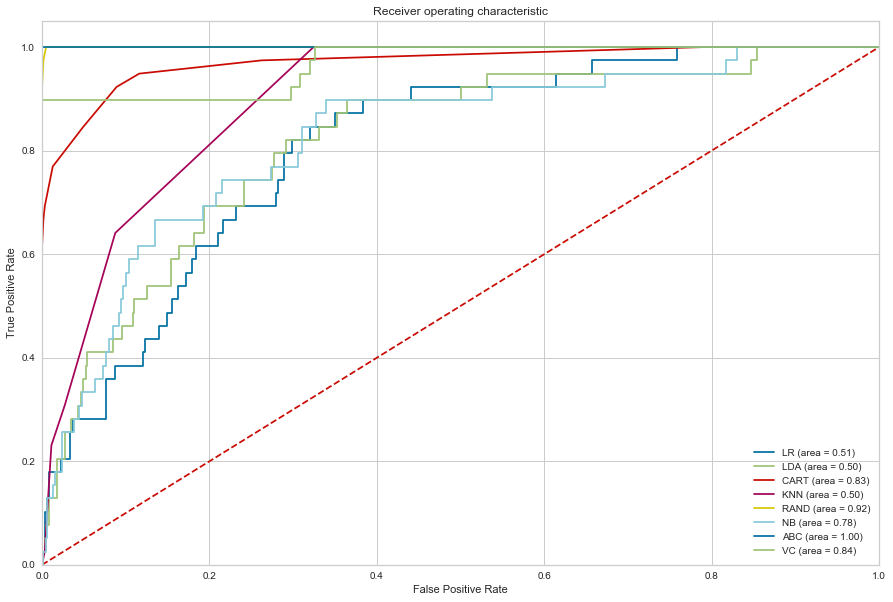

In [188]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def draw_roc():
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1],'r--')

    for name, model in models:
        logit_roc_auc = roc_auc_score(y, model.predict(X))
        fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
        plt.plot(fpr, tpr, label=name + ' (area = %0.2f)' % logit_roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    
draw_roc()

#### As per ROC curv best results are given by models with area near 1. (RAND, ABC, VC)

In [189]:
import plotly as py
import plotly.graph_objs as go
from plotly import tools

py.offline.init_notebook_mode(connected=True)

# d already has predictions from last model, we only want to check output of last model which is VC
d['KICKER_SEAS']=d['KICKER_NAME'] 
#print(d['KICKER_NAME'] + " " + d['SEASON'])

model_results_true_negative = d.loc[(d['IN_PROBOWL_TEAM'] == 0) & (d['PREDICTION'] == 0)]
model_results_false_negative = d.loc[(d['IN_PROBOWL_TEAM'] == 1) & (d['PREDICTION'] == 0)]
model_results_false_positive = d.loc[(d['IN_PROBOWL_TEAM'] == 0) & (d['PREDICTION'] == 1)]
model_results_true_positive = d.loc[(d['IN_PROBOWL_TEAM'] == 1) & (d['PREDICTION'] == 1)]

def add_trace(x_axis,y_axis,text, showlegend):
    trace=[]
    # Create a trace
    trace.append(go.Scatter(
        x = model_results_true_negative[x_axis],
        y = model_results_true_negative[y_axis],
        mode = 'markers',
        name = 'Non-ProBowler',
            marker = dict(
            size = 5,
            color = 'rgba(100, 152, 200, .8)'),
        text= model_results_true_negative[text],
        showlegend=showlegend
    ))

    trace.append(go.Scatter(
        x = model_results_false_negative[x_axis],
        y =model_results_false_negative[y_axis],
        mode = 'markers',
        name = 'Missed an actual ProBowler',
            marker = dict(
            size = 10,
            color = 'rgba(50, 25, 150, .8)'),
        text= model_results_false_negative[text],
        showlegend=showlegend
    ))

    trace.append(go.Scatter(
         x = model_results_false_positive[x_axis],
        y = model_results_false_positive[y_axis],
        mode = 'markers',
        name = 'Incorrectly Predicted ProBowl',
            marker = dict(
            size = 10,
            color = 'rgba(0, 152, 50, .8)'),
       text= model_results_false_positive[text],
        showlegend=showlegend
    ))

    trace.append(go.Scatter(
        x = model_results_true_positive[x_axis],
        y = model_results_true_positive[y_axis],
        mode = 'markers',
        name = 'Pro-Bowler',
            marker = dict(
            size = 10,
            color = 'rgba(152, 0, 0, .8)'),
        text= model_results_true_positive[text],
        showlegend=showlegend
    ))
    
    return trace
    
def plot():
    fig = tools.make_subplots(rows=5, cols=1, subplot_titles=('Overall', 'High Pressure',
                                                          'Long Distance', 'Bad Weather',
                                                         'Turf field'))
    for r in range(1,6):
        for c in range(1,2):           
            if(r==1 and c==1):           
                x='PLAY_COUNT'
                y='SUCCESS_PRCNTG'
                text='KICKER_SEAS'
                x_axis_label='Kicks Attempted'
                y_axis_label='Success Percentage'
                title='Kickers & ProBowls'
                showlegend=True
            elif(r==2 and c==1):  
                x='HIGH_PRESSURE_COUNT'
                y='HIGH_PRESSURE_SUCCESS_PRCNTG'
                text='KICKER_SEAS'
                x_axis_label='All Kicks Attempted'
                y_axis_label='Overall Success Percentage'
                title='Kickers & ProBowls (High Pressure)'
                showlegend=False
            elif(r==3 and c==1):  
                x='LONG_DIST_COUNT'
                y='LONG_DIST_SUCCESS_PRCNTG'
                text='KICKER_SEAS'
                x_axis_label='Kicks Attempted'
                y_axis_label='Success Percentage'
                title='Kickers & ProBowls (long Distance)'
                showlegend=False
            elif(r==4 and c==1):  
                x='BAD_WEATHER_COUNT'
                y='BAD_WEATHER_SUCCESS_PRCNTG'
                text='KICKER_SEAS'
                x_axis_label='Kicks Attempted'
                y_axis_label='Success Percentage'
                title='Kickers & ProBowls (long Distance)'
                showlegend=False
            elif(r==5 and c==1):  
                x='TURF_FIELD_COUNT'
                y='TURF_FIELD_SUCCESS_PRCNTG'
                text='KICKER_SEAS'
                x_axis_label='Kicks Attempted'
                y_axis_label='Success Percentage'
                title='Kickers & ProBowls (Turf field)'
                showlegend=False
                
            trace = add_trace(x, y, text, showlegend)
            layout = go.Layout(
                title=title,
                xaxis=dict(
                    title= x_axis_label,
                    titlefont=dict(
                        family='Courier New, monospace',
                        size=18,
                        color='#7f7f7f'
                    )
                ),
                yaxis=dict(
                    title= y_axis_label,
                    titlefont=dict(
                        family='Courier New, monospace',
                        size=18,
                        color='#7f7f7f'
                    )
                )
            ) 
            
            fig.append_trace(trace[0], r, c)
            fig.append_trace(trace[1], r, c)
            fig.append_trace(trace[2], r, c)
            fig.append_trace(trace[3], r, c)
            
            #scatter_pb = go.Figure(data = [trace3, trace2, trace1, trace0], layout=layout)
            #fig['layout'] = layout
    
    
    fig['layout']['xaxis5'].update(title='Kicks Attempted')
    #fig['layout']['xaxis5'].update(title='xaxis 2 title', range=[10, 50])
    
    fig['layout']['yaxis1'].update(title='Success Percentage')
    fig['layout']['yaxis3'].update(title='Success Percentage')
    fig['layout']['yaxis5'].update(title='Success Percentage')

    fig['layout'].update(height=1000, width=1000, title='Kickers & ProBowls')    
    py.offline.iplot(fig)

plot()

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]
[ (5,1) x5,y5 ]



C:\Users\deeka\Anaconda3\envs\GTU\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

